## La spiegazione di questo codice forse la metto forse no, sicuro fa riferimento a record_linkage

In [2]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

### Stai attento peró che con l'approccio sotto riportato 2 righe matchano solo se entrambi i valori fanno match

In [4]:
import recordlinkage
import pandas as pd


def block_city_or_country(df):
    indexer = recordlinkage.Index()

    # Separiamo le righe con città non nulli da quelle con città nulli
    df_non_null_city = df.dropna(subset=['city'])
    df_null_city = df[df['city'].isnull()]

    # Primo blocco solo sulle righe con città non null
    indexer.block(left_on=['city'])
    candidate_pairs_city = indexer.index(df_non_null_city)
    print(f'Numero di coppie candidate sulla città: {len(candidate_pairs_city)}')

    # Inizializza le coppie finali con quelle candidate sulla città
    candidate_pairs_final = candidate_pairs_city.copy()

    # Ora gestiamo il caso delle righe con città null
    for idx_left, idx_right in candidate_pairs_city:
        city_left = df.loc[idx_left, 'city']
        city_right = df.loc[idx_right, 'city']
        
        # Se le città sono diverse o entrambe null, controlliamo sul paese
        if city_left != city_right or pd.isnull(city_left) or pd.isnull(city_right):
            # Blocchiamo solo se le città sono diverse o nulli
            indexer = recordlinkage.Index()
            indexer.block(left_on=['country'])
            candidate_pairs_country = indexer.index(df)
            
            # Aggiungiamo solo le coppie che matchano sul paese
            for country_pair in candidate_pairs_country:
                if (idx_left, idx_right) == country_pair:
                    candidate_pairs_final = candidate_pairs_final.append([country_pair])

    return candidate_pairs_final

# Usa la funzione per ottenere le coppie finali
candidate_pairs = block_city_or_country(companies_df)
print(f'Numero totale di coppie candidate: {len(candidate_pairs)}')


Numero di coppie candidate sulla città: 3693056
Numero totale di coppie candidate: 3693056


In [5]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

compare = Compare()
compare.string('sector', 'sector', method='jarowinkler', threshold=0.85, label='sector')
compare.string('company_name', 'company_name', method='jarowinkler', threshold=0.85, label='company_name')
compare.string('categories', 'categories', method='jarowinkler', threshold=0.85, label='categories')
compare.string('company_status', 'company_status', method='jarowinkler', threshold=0.85, label='company_status')
compare.string('website', 'website', method='jarowinkler', threshold=0.85, label='website')


try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

sector  company_name  categories  company_status  website
left  right                                                           
4319  7         0.0           0.0         0.0             0.0      0.0
6600  7         0.0           0.0         0.0             0.0      1.0
      4319      0.0           0.0         0.0             0.0      0.0
13081 7         0.0           0.0         0.0             0.0      1.0
      4319      0.0           0.0         0.0             0.0      0.0
      6600      0.0           0.0         0.0             0.0      1.0
13082 7         0.0           0.0         0.0             0.0      1.0
      4319      0.0           0.0         0.0             0.0      0.0
      6600      0.0           0.0         0.0             0.0      1.0
      13081     0.0           1.0         0.0             0.0      1.0

In [6]:
matches = features[features.sum(axis=1) > 1.5]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 6311


,,sector,company_name,categories,company_status,website
left,right,,,,,
13082,13081,0.0,1.0,0.0,0.0,1.0
2091,2069,1.0,1.0,0.0,0.0,0.0
7563,7562,0.0,1.0,0.0,0.0,1.0
10072,10070,0.0,1.0,0.0,0.0,1.0
10870,2037,1.0,0.0,0.0,0.0,1.0


In [7]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)

,,sector,company_name,categories,company_status,website
left,right,,,,,
13,12,0.0,1.0,0.0,0.0,1.0
33,32,0.0,1.0,0.0,0.0,1.0
59,58,0.0,1.0,0.0,0.0,1.0
91,89,0.0,1.0,0.0,0.0,1.0
139,138,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2398,2397,0.0,1.0,0.0,0.0,1.0
2409,2408,0.0,1.0,0.0,0.0,1.0
2454,444,0.0,1.0,0.0,0.0,1.0


In [8]:
import networkx as nx

def merge_values(series):
    unique_values = set(series.dropna()) 
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  
G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

connected_components = list(nx.connected_components(G))

duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

companies_df['group_id'] = companies_df.index.map(duplicate_groups)

def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  
        print(group_data[['company_name', 'city', 'country', 'address']])  

final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

final_df = final_df.drop(columns=['group_id'])

for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

final_df.to_csv("deduplicated_companies2.csv", index=False)

display(final_df.head())


Aggregazione del gruppo 16.0 (con 4 elementi):
            company_name    city         country  \
0    abellio east anglia  london  united kingdom   
1    abellio east anglia  london  united kingdom   
2  abellio east midlands  london  united kingdom   
3  abellio east midlands  london  united kingdom   

                                             address  
0  2nd floor st andrews house, 18-20 st. andrew s...  
1  2nd floor st andrews house, 18-20 st. andrew s...  
2  2nd floor st andrew's house 18-20 st andrew st...  
3  2nd floor st andrew's house 18-20 st andrew st...  

Aggregazione del gruppo 28.0 (con 6 elementi):
          company_name    city         country  \
0            accenture  london  united kingdom   
1            accenture  london  united kingdom   
2       accenture (uk)  london  united kingdom   
3       accenture (uk)  london  united kingdom   
4  accenture marketing  london  united kingdom   
5  accenture marketing  london  united kingdom   

                 

,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,address,postal_code,...,emtak_code,nace_code,facebook,twitter,pinterest,instagram,investors,region,notes_or_description,modified
0,3694 | 1804,1-800-flowers.com,1-800-flowers.com,,,,,,2 jericho plz ste 200,117531681,...,,,,,,,,,headquarter,False
1,4300 | 1500,123-reg,,,,,,,"5th floor the shipping building old viny, 252-...",ub3 1ha,...,,,,,,,,,headquarter,False
2,267 | 3414,24,,,,,,,vaike-turu tn 5-81,51004,...,,,,,,,,,headquarter,False
3,,360 capital reit | 360 capital,,,,,,,,,...,,,,,,,,,,True
4,4650 | 1194,3m innovative properties,| 3m,,,,,,3m center bldg 225 3s 06,551441001,...,,,,,,,,,headquarter,False


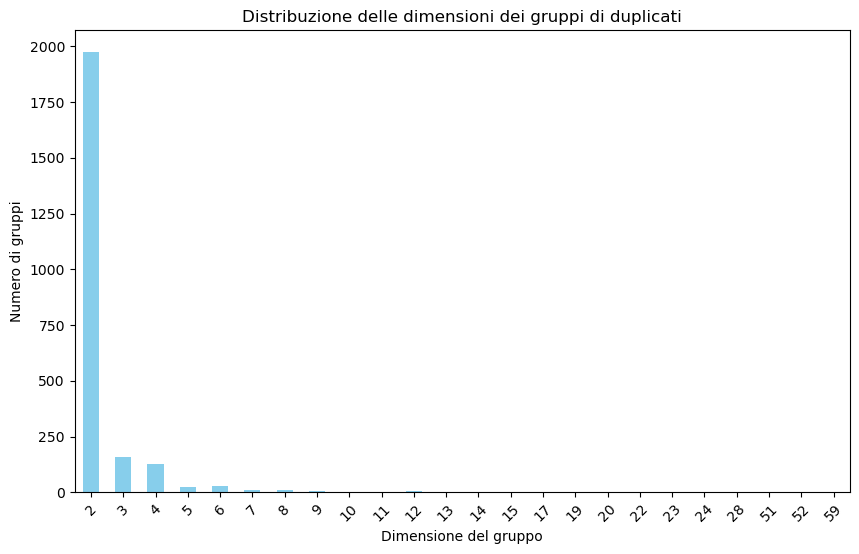

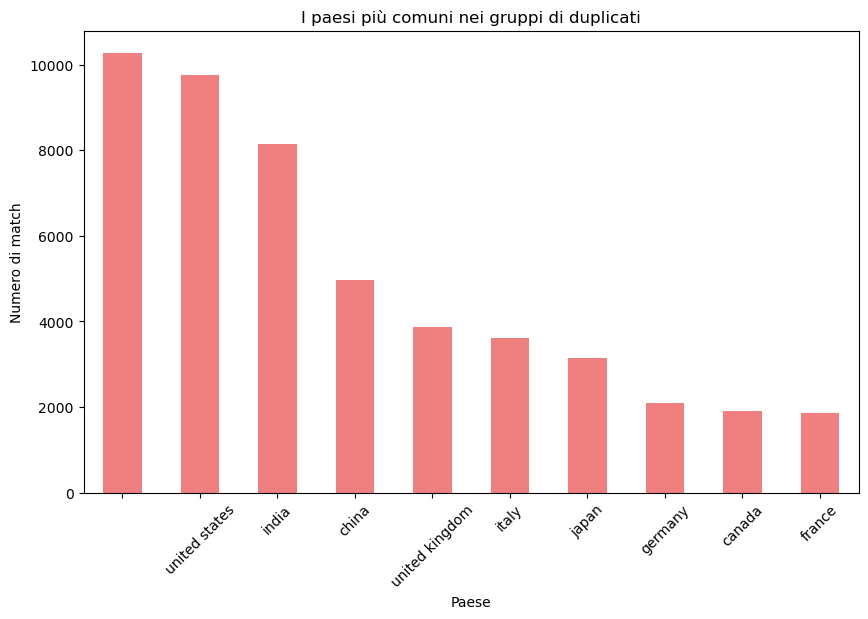

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


group_sizes = companies_df.groupby('group_id').size()

group_sizes_filtered = group_sizes[group_sizes > 1]

plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()


country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()